In [1]:
import pandas as pd

dat = pd.read_csv('Crimes_-_2001_to_present.csv')
dat.head(5)

C:\Users\henry\AppData\Local\Temp\ipykernel_48916\710893603.py:3: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  dat = pd.read_csv('Crimes_-_2001_to_present.csv')


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11034701,JA366925,01/01/2001 11:00:00 AM,016XX E 86TH PL,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,...,8.0,45.0,11,NaN,NaN,2001,08/05/2017 03:50:08 PM,NaN,NaN,NaN
1,11227287,JB147188,10/08/2017 03:00:00 AM,092XX S RACINE AVE,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,...,21.0,73.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
2,11227583,JB147595,03/28/2017 02:00:00 PM,026XX W 79TH ST,0620,BURGLARY,UNLAWFUL ENTRY,OTHER,False,False,...,18.0,70.0,05,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
3,11227293,JB147230,09/09/2017 08:17:00 PM,060XX S EBERHART AVE,0810,THEFT,OVER $500,RESIDENCE,False,False,...,20.0,42.0,06,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
4,11227634,JB147599,08/26/2017 10:00:00 AM,001XX W RANDOLPH ST,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,HOTEL/MOTEL,False,False,...,42.0,32.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN


In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as Fs

spark = SparkSession.builder.getOrCreate()
df_spark = spark.read.options(header = 'True', inferSchema='True').csv('Crimes_-_2001_to_present.csv')

In [3]:
df_spark.show(5)

+--------+-----------+--------------------+--------------------+----+-------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+
|      ID|Case Number|                Date|               Block|IUCR|       Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|Latitude|Longitude|Location|
+--------+-----------+--------------------+--------------------+----+-------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+
|11034701|   JA366925|01/01/2001 11:00:...|     016XX E 86TH PL|1153| DECEPTIVE PRACTICE|FINANCIAL IDENTIT...|           RESIDENCE| false|   false| 412|       4|   8|            45|      

In [6]:
from pyspark.sql.functions import to_date, month, col

df_spark = df_spark.withColumn('Date', to_date(col("Date"), 'MM/dd/yyyy hh:mm:ss a'))
df_spark = df_spark.withColumn("Month", month(col("Date")))

# Register the DataFrame as a temporary table
df_spark.createOrReplaceTempView("crimes")

# Use SparkSQL to find the count of crime events by month
result = spark.sql("""
    SELECT Month, COUNT(*) as crime_events
    FROM crimes
    GROUP BY Month
    ORDER BY Month
""")

# Collect the results to a Pandas DataFrame
pd_result = result.toPandas()

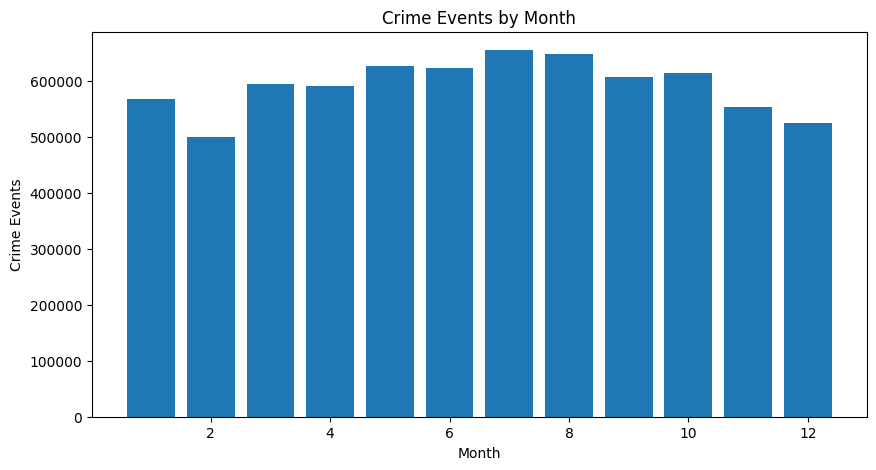

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(pd_result['Month'], pd_result['crime_events'])
plt.xlabel('Month')
plt.ylabel('Crime Events')
plt.title('Crime Events by Month')
plt.show()

In [9]:
df_spark.show(5)

+--------+-----------+----------+--------------------+----+-------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+-----+
|      ID|Case Number|      Date|               Block|IUCR|       Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|Latitude|Longitude|Location|Month|
+--------+-----------+----------+--------------------+----+-------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+-----+
|11034701|   JA366925|2001-01-01|     016XX E 86TH PL|1153| DECEPTIVE PRACTICE|FINANCIAL IDENTIT...|           RESIDENCE| false|   false| 412|       4|   8|            45|      11|        null|      

In [10]:
from pyspark.sql import SparkSession

# Create Spark session
spark = SparkSession.builder.appName("crime_analysis").getOrCreate()

# Read the dataframe

# Filter events of the last 3 years
df_3years = df_spark.filter(df_spark['Year'] >= 2020)

# Count and sort crime events by block
top10_blocks = df_3years.groupBy("Block").count().orderBy('count', ascending=False).limit(10)
top10_blocks.show()


+--------------------+-----+
|               Block|count|
+--------------------+-----+
|    001XX N STATE ST|  231|
| 0000X W TERMINAL ST|   96|
|008XX N MICHIGAN AVE|   90|
|064XX S DR MARTIN...|   75|
|  076XX S CICERO AVE|   69|
|     0000X W 79TH ST|   67|
|    100XX W OHARE ST|   66|
|    0000X S STATE ST|   66|
|   025XX W CERMAK RD|   64|
| 083XX S STEWART AVE|   61|
+--------------------+-----+



In [1]:
from pyspark import SparkConf, SparkContext
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

from pyspark import SparkConf, SparkContext

conf = SparkConf().setAppName("CrimeAnalysis")
sc = SparkContext(conf=conf)
# crime_data = sc.textFile('Crimes_-_2001_to_present.csv')


In [16]:
def check_year(x):
    try:
        year = int(x[17])
        return year in [2020,2021,2022]
    except :
        print(f"ValueError for record {x}")
        return False

# data_last_3_years = data.filter(check_year)


In [9]:
time.strftime("%Y")

'2023'

In [3]:
myRDD = sc.parallelize([1,2,3,4,5],2)
myRDD.collect()

[1, 2, 3, 4, 5]

In [17]:
import time
# Read the data
data = sc.textFile("Crimes_-_2001_to_present.csv")
header = data.first()
data = data.filter(lambda line: line != header).map(lambda line: line.split(","))

data_year = data.map(lambda x: ())
# Filter to get data from last 3 years
current_year = int(time.strftime("%Y"))
data_last_3_years = data.filter(check_year)

# Get the block and its count
block_counts = data_last_3_years.map(lambda x: (x[3][:5], 1)).reduceByKey(lambda a, b: a + b)

# Get top 10 blocks
top_10_blocks = block_counts.sortBy(lambda x: x[1], ascending=False).take(10)

print(top_10_blocks)

[('0000X', 2052), ('001XX', 1583), ('002XX', 1296), ('003XX', 1197), ('012XX', 1139), ('008XX', 1092), ('015XX', 1073), ('006XX', 1065), ('011XX', 1040), ('013XX', 1037)]


In [18]:
with open("liang_2_1.txt", "w") as file:
        file.write("Block, Count\n")
        for block, count in top_10_blocks:
            file.write(f"{block}, {count}\n")

In [46]:
from datetime import datetime, timedelta
data = sc.textFile("Crimes_-_2001_to_present.csv")
header = data.first()
data = data.filter(lambda line: line != header).map(lambda line: line.split(","))
def check_year(x):
    try:
        year = int(x[17])
        return year >= 2018
    except :
        print(f"ValueError for record {x}")
        return False
    
# Filter the DataFrame for the last five years
df_filtered = data.filter(lambda x: x[17] in ['2020', '2019', '2018', '2017', '2016'])

In [48]:
x = df_filtered.map(lambda row: ((row[10], row[17]), 1)).reduceByKey(lambda a, b: a + b)

In [61]:
x.take(5)

[(('2513', '2018'), 433),
 (('1224', '2018'), 1108),
 (('0214', '2018'), 652),
 (('1934', '2019'), 1015),
 (('0812', '2019'), 593)]

In [66]:
# Continue from where your code left off.
# Transform the data to have the beat as key and list of values as value.
beat_year = x.map(lambda x: (x[0][0], (x[0][1], x[1])))

# Group by the beat key and collect all values for each key into a list.
beat_grouped = beat_year.groupByKey().mapValues(list)

beat_counts = beat_grouped.mapValues(lambda x: [count for year, count in x])

# Finally, collect the RDD into a dictionary.
beat_dict = beat_counts.collectAsMap()
beat_dict

{'0915': [831, 816, 208],
 '1215': [171, 804, 844],
 '0831': [1216, 1329, 345],
 '1114': [781, 732, 171],
 '1013': [1114, 244, 1058],
 '0722': [730, 210, 763],
 '0231': [171, 874, 757],
 '0433': [750, 633, 181],
 '0815': [1199, 264, 973],
 '1633': [246, 951, 827],
 '0313': [930, 196, 820],
 '1622': [819, 226, 929],
 '2013': [110, 560, 428],
 '2535': [258, 805, 858],
 '1411': [147, 684, 581],
 '1812': [691, 823, 174],
 '2422': [1327, 1297, 330],
 '0632': [1518, 369, 1466],
 '0834': [291, 1162, 1141],
 '0211': [904, 229, 915],
 '1931': [657, 175, 695],
 '1011': [1932, 479, 1795],
 '0621': [1717, 402, 1760],
 '1032': [546, 558, 154],
 '0932': [161, 669, 746],
 '1832': [1215, 232, 1109],
 '1134': [1168, 1507, 254],
 '0413': [1105, 293, 1093],
 '2411': [894, 234, 972],
 '0423': [1788, 370, 1912],
 '0914': [238, 854, 868],
 '0922': [241, 840, 844],
 '0531': [945, 200, 866],
 '2022': [112, 402, 316],
 '1924': [243, 1249, 1156],
 '2012': [562, 116, 438],
 '2524': [513, 141, 524],
 '0911': [483

In [68]:
corr_mat = np.corrcoef(list(beat_dict.values()))

In [75]:
import numpy as np
corr_dict = {}
beat_keys = list(beat_dict.keys())
for i in range(len(beat_keys)):
    for j in range(i+1, len(beat_keys)):
        beat1 = beat_keys[i]
        beat2 = beat_keys[j]
        corr = corr_mat[i, j]
        corr_dict[(beat1, beat2)] = corr
sorted_corr_dict = dict(sorted(corr_dict.items(), key=lambda item: np.abs(item[1]), reverse=True))

In [76]:
sorted_corr_dict

{('1923', '1233'): 0.999999999778903,
 ('1114', '1621'): 0.9999999996253134,
 ('0331', '2413'): 0.9999999994866706,
 ('1011', '1431'): 0.9999999967778757,
 ('0821', '1513'): 0.9999999962439929,
 ('1221', '2534'): 0.9999999950752096,
 ('0913', '0725'): 0.9999999850669078,
 ('0624', '0324'): 0.9999999842492863,
 ('1222', '2221'): 0.9999999796807041,
 ('0612', '0634'): 0.9999999779830203,
 ('0312', '1532'): 0.9999999765785702,
 ('0524', '1531'): 0.9999999717491707,
 ('0231', '1921'): 0.9999999715802663,
 ('0831', '0114'): 0.9999999700128569,
 ('2512', '0735'): 0.9999999695034865,
 ('1231', '1414'): 0.999999961349001,
 ('2024', '0814'): 0.999999960435069,
 ('0812', '1233'): 0.9999999585349819,
 ('1522', '0113'): 0.999999958173597,
 ('1013', '1213'): 0.9999999545301785,
 ('1923', '0812'): 0.999999952258213,
 ('2532', '0714'): 0.9999999481797792,
 ('1924', '1421'): 0.9999999302655358,
 ('1232', '2232'): 0.9999999282308619,
 ('1031', '2515'): 0.999999921377472,
 ('2533', '0123'): 0.9999999188

In [27]:
beat_counts = df_filtered.map(lambda row: (row[10], row[17])).countByValue()
beat_list = []
for beat in set([beat_year[0] for beat_year in beat_counts.keys()]):
    beat_list.append([beat_counts[(beat, str(year))] if (beat, str(year)) in beat_counts else 0 for year in range(datetime.now().year - 5, datetime.now().year)])

# Calculate the correlation matrix
correlation_matrix = Statistics.corr(sc.parallelize(beat_list), method="pearson")

print(correlation_matrix)

[[1.         0.97976189 0.91849863        nan        nan]
 [0.97976189 1.         0.93590701        nan        nan]
 [0.91849863 0.93590701 1.                nan        nan]
 [       nan        nan        nan 1.                nan]
 [       nan        nan        nan        nan 1.        ]]


In [28]:
beat_counts

defaultdict(int,
            {('1113', '2018'): 1121,
             ('1935', '2018'): 1014,
             ('2433', '2018'): 835,
             ('1651', '2018'): 487,
             ('0133', '2018'): 822,
             ('1123', '2018'): 1083,
             ('1654', '2018'): 295,
             ('1913', '2018'): 732,
             ('1232', '2018'): 1141,
             ('2522', '2018'): 665,
             ('2513', '2018'): 433,
             ('1134', '2018'): 1507,
             ('1821', '2018'): 1457,
             ('1612', '2018'): 350,
             ('1712', '2019'): 946,
             ('1021', '2018'): 1105,
             ('1233', '2019'): 952,
             ('2515', '2018'): 1078,
             ('0834', '2018'): 1141,
             ('0912', '2018'): 821,
             ('0932', '2018'): 746,
             ('1925', '2018'): 973,
             ('1224', '2018'): 1108,
             ('1413', '2019'): 492,
             ('2423', '2018'): 560,
             ('1633', '2018'): 951,
             ('2533', '2018'): 1648,


In [24]:
from pyspark.mllib.stat import Statistics

# Compute the number of crimes per beat per year
beat_counts = df_filtered.map(lambda row: ((row[10], row[17]), 1))\
                             .reduceByKey(lambda a, b: a + b)\
                             .map(lambda row: (row[0][0], (row[0][1], row[1])))\
                             .groupByKey()\
                             .mapValues(dict)

# Prepare the RDD for the correlation computation
# correlation_rdd = beat_counts.cartesian(beat_counts)\
#                              .filter(lambda x: x[0][0] != x[1][0])\
#                              .map(lambda x: (x[0][0], x[1][0], Statistics.corr(list(x[0][1].values()), list(x[1][1].values()), method="pearson")))


In [9]:
flattened_beat_counts = beat_counts.flatMap(lambda x: [(x[0], year, count) for year, count in x[1].items()])

correlation_rdd = flattened_beat_counts.cartesian(flattened_beat_counts)\
                             .filter(lambda x: x[0][0] != x[1][0])\
                             .map(lambda x: (x[0][0], x[1][0], Statistics.corr(x[0][2], x[1][2], method="pearson")))


In [33]:
from pyspark.mllib.stat import Statistics
rdd1 = sc.parallelize(range(1, 5))
rdd2 = sc.parallelize(range(1, 5))
print("Correlation: ", Statistics.corr(rdd1, rdd2, method="pearson"))


Correlation:  1.0000000000000002


In [34]:
check_types_rdd = beat_counts.cartesian(beat_counts)\
                             .filter(lambda x: x[0][0] != x[1][0])\
                             .map(lambda x: (x[0][0], x[1][0], type(list(x[0][1].values())), type(list(x[1][1].values()))))

for record in check_types_rdd.take(5):
    print(record)


('0915', '1215', <class 'list'>, <class 'list'>)
('0915', '0831', <class 'list'>, <class 'list'>)
('0915', '1114', <class 'list'>, <class 'list'>)
('0915', '1013', <class 'list'>, <class 'list'>)
('1215', '0915', <class 'list'>, <class 'list'>)


In [25]:
for record in beat_counts.take(5):
    print(record)


('0915', {'2019': 831, '2018': 816, '2020': 208})
('1215', {'2020': 171, '2018': 804, '2019': 844})
('0831', {'2019': 1216, '2018': 1329, '2020': 345})
('1114', {'2019': 781, '2018': 732, '2020': 171})
('1013', {'2018': 1114, '2020': 244, '2019': 1058})


In [26]:
beat_list = []
for beat in beat_counts.keys():
    beat_list.append([beat_counts[(beat, year)] if (beat, year) in beat_counts else 0 for year in range(datetime.now().year - 5, datetime.now().year)])

# Calculate the correlation matrix
correlation_matrix = Statistics.corr(sc.parallelize(beat_list), method="pearson")

print(correlation_matrix)

TypeError: 'PipelinedRDD' object is not iterable

In [36]:
correlation_list = correlation_rdd.collect()
correlation_list.sort(key=lambda x: -x[2])


Traceback (most recent call last):
  File "c:\Users\henry\OneDrive\Desktop\MSiA\msia_env\lib\site-packages\pyspark\serializers.py", line 459, in dumps
    return cloudpickle.dumps(obj, pickle_protocol)
  File "c:\Users\henry\OneDrive\Desktop\MSiA\msia_env\lib\site-packages\pyspark\cloudpickle\cloudpickle_fast.py", line 73, in dumps
    cp.dump(obj)
  File "c:\Users\henry\OneDrive\Desktop\MSiA\msia_env\lib\site-packages\pyspark\cloudpickle\cloudpickle_fast.py", line 632, in dump
    return Pickler.dump(self, obj)
  File "c:\Users\henry\OneDrive\Desktop\MSiA\msia_env\lib\site-packages\pyspark\context.py", line 462, in __getnewargs__
    raise RuntimeError(
RuntimeError: It appears that you are attempting to reference SparkContext from a broadcast variable, action, or transformation. SparkContext can only be used on the driver, not in code that it run on workers. For more information, see SPARK-5063.


PicklingError: Could not serialize object: RuntimeError: It appears that you are attempting to reference SparkContext from a broadcast variable, action, or transformation. SparkContext can only be used on the driver, not in code that it run on workers. For more information, see SPARK-5063.